<a href="https://colab.research.google.com/github/psukphranee/Python-Practice/blob/master/SAR_Scratch_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import scipy.sparse as sp

#I. Introduction

> A satellite antenna emits a chirp pulse train towards the ground some distance away. The signal has a PRF of 10kHz with 10% duty-time. The signal bounces off of the ground directly back at the antenna. The antenna picks the signal up at a sampling rate of 1GHz. The ground will be model as an LTI system. Thus, the reflected signal is the convolution of the incoming signal (incoming into the ground) with the impulse response of the ground.

 > This notebook will give a rundown of the principles involved and implementation details and logic using Python. The ideas will be finally be implemented in C++.

##Sampling Frequency

###Data Points

> The sampling frequency of 1GHz determines the number of data points in our implementation. We'll have $1GHz \approx 1024$ datapoints per second.


###Nyquist Rate

> The sampling frequency imposes a limit of the signal frequency we can reconstruct. 

> $f_s > 2 f_m$ or $\dfrac{f_s}{2} > f_m$.

> Thus, the maximum frequency of the chirp pulse is limited to $\dfrac{f_s}{2} = .5GHz = 500MHz$.

##Signal - Chirp Pulse

The signal is described by

$P(t) = \chi_{\tau}(t) e^{j 2 \pi (f_c t + \frac{1}{2}k t^2)}$. (Cheney; Ho Doo, Smith, Baker).

Where 

$
\chi_{\tau}(t)=
    \begin{cases}
        A & \text{if } t \in [0, \tau] \\
        0 & otherwise
    \end{cases}
$

###Carrier Frequency and Chirp Rate Constraints
The **pulse width**, $\tau$, is calculated as the duty time divided by the pulse repetition frequency,

$
\tau = \dfrac{D}{PRF} = \dfrac{.1}{10^4} = 10^{-5}s.
$

We can choose our carrier frequency and chirp rate so that we don't exceed $f_m = 500MHz$ over the pulse duration $\tau$.

$f_c + \dfrac{10^{-5}}{2}k < 500MHz$.

Text(0, 0.5, 'MHz/sec')

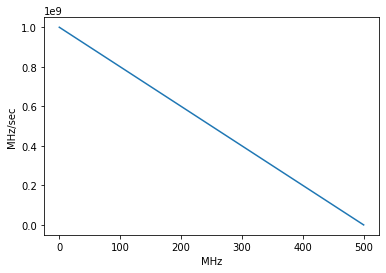

In [3]:
plt.plot([0, 500],[10e8, 0])
# plt.yscale('log')
plt.xscale('linear')
# plt.xlim([0, 500])
plt.xlabel('MHz')
plt.ylabel('MHz/sec')

##LTI System - Ground Reflection

Signals incident on the ground are modeled with geometric optics. The rays incident at different points of the ground are backscattered with different delay times. The ground illuminated is modeled as a the superposition of all impulse responses from each scatter point.

For each ground scatter point $g_i$, the impulse response is 

$
  H_i \delta(t) = \delta(t - \tau_i)
$. ie, the response is a delayed input. The total system response is then the sum of all point scatters,

$
\begin{align}
h(t) &:= H \delta(t) \\
&= \sum H_i \delta(t) \\
&= \sum \delta(t - \tau_i).
\end{align}
$


The reflected signal is then given by


$
\begin{align}
  P_R(t) &= P(t) \star h(t) \\
    &= P(t) \star \sum \delta(t - \tau_i) \\
    &=  \sum  P(t) \star\delta(t - \tau_i) \\
    &= \sum P(t - \tau_i)
\end{align}
$

#II. Implementation


##Pulse Generating Functions

```plot_train(time_absolute, time_modulus, train)```

```generate_pulse_envelope(time_array, pulse_width, pulse_height)```

```generate_pulse_wave(time_array, chirp_rate, carrier_frequency)```

```generate_LFM_Pulse(time_array, pulse_width, pulse_height, chirp_rate, carrier_frequency)```

In [4]:
#Helper Functions

def plot_train(time_absolute, time_modulus, train):

  fig, ax = plt.subplots(2,1, figsize=(20,8))
  ax[0].plot(t[0,:], train[0,:], alpha=0.5)
  ax[1].plot(t[0,:], t_mod[0,:], alpha=0.5)

  # ax[0].set_title("Pulse Envelope")
  ax[1].set_title("Verify Periodicity")
  plt.show()

In [5]:
def generate_pulse_envelope(time_array, pulse_width=1e-5, pulse_height=1):
  #this function returns pulse envelopes of tau width wide. the left edge of the envelope is located at any zeros of the time array.

  t = time_array;
  A = pulse_height;
  tau = pulse_width; 
  tau_half = tau/2;

  chi = A * (np.abs((t-tau_half)/tau_half) <= 1);

  return chi;

In [57]:
def generate_pulse_wave(time_array, chirp_rate=0, carrier_frequency=500e6):
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency
  # #argument to be passed to exponenetial 
  exp_arg = 2j*np.pi*(f_c*t + .5*k*(np.square(t)))
  LFM = np.exp(exp_arg);

  return LFM

In [7]:
def generate_LFM_Pulse(time_array, pulse_width=1, pulse_height=1, chirp_rate=1, carrier_frequency=100):
  
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #pulse envelope  ---------------
  chi = generate_pulse_envelope(t, pulse_height=pulse_height, pulse_width=pulse_width);

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency

  LFM = generate_pulse_wave(t, k, f_c)

  pulse = chi * LFM;

  return pulse

##Function Demos

The time vector passed to the pulse generating functions are pre-processed by division mod PRT. The result doesn't come out perfectly periodic possibly due to numerical error.

In [61]:
#define parameters
f_s = 1e6; #sampling rate; data points per second 
PRF = 10e3; #10kHz
D = .1 #duty time

PRT = np.reciprocal(PRF)
f_m = f_s/2
tau = D*PRT

#
A = 1 #pulse height
k = 0 #chirp rate
f_c = 200e6 #carrier freq

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


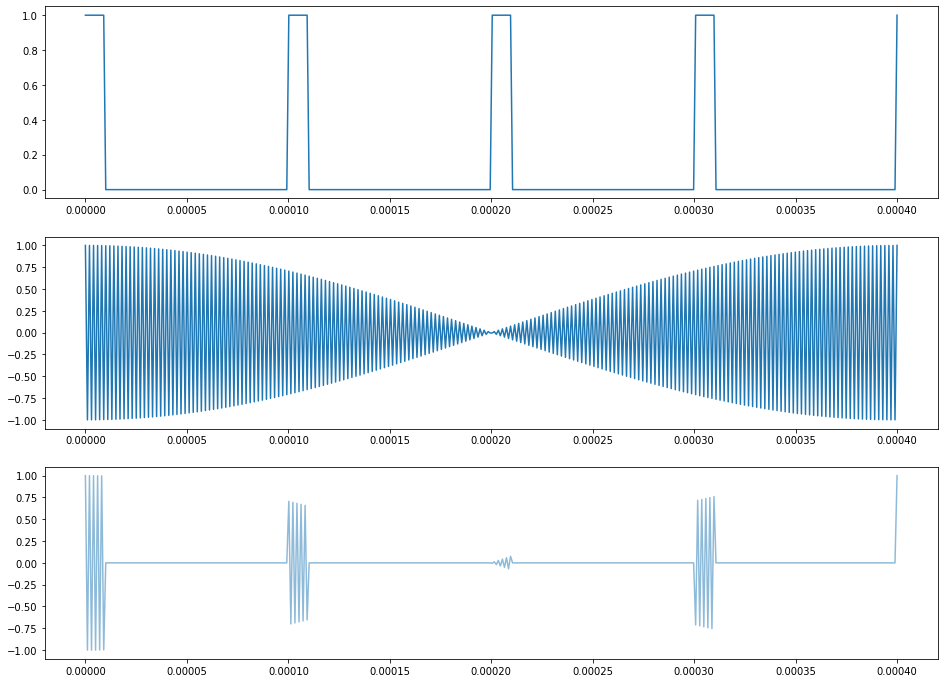

In [63]:
t_end = PRT*4 #multiple of pulse repittion period
t = np.linspace(0, t_end, int(f_s*t_end)).reshape(1,-1)
t_mod = np.mod(t, PRT)

pulse_envelope = generate_pulse_envelope(time_array=t_mod, pulse_width=tau, pulse_height=1)
pulse_wave = generate_pulse_wave(time_array=t_mod, chirp_rate=k, carrier_frequency=f_c)
pulse = generate_LFM_Pulse(time_array=t_mod, pulse_width=tau, pulse_height=1, chirp_rate=k, carrier_frequency=f_c)

fig, ax = plt.subplots(3,1, figsize=(16, 12))
ax[0].plot(t[0,:], pulse_envelope[0,:])
ax[1].plot(t[0,:], pulse_wave[0,:])
ax[2].plot(t[0,:], pulse[0,:], alpha=0.5)
plt.show()

##

##Ground LTI System

We represent the ground with a row vector $\vec{g}$ of length $n_g$ and elements corresponding to time delays,

$g[k] = \tau_k$. 

To simplify, assume that the step sizes are constant, $g[k+1] - [k] =: \Delta \tau$ are the same for all $k$. Then we have,

$g[k] = k \cdot \Delta \tau$.

The time delay steps corresponding to the ground ($\Delta \tau$) may be different and probably finer than the temporal step size corresponding to the sampling rate. We have to scale accordingly to sum up the correct data points. 

In [64]:
#let ds be the temporal step corresponding to the sample rate
ds = np.reciprocal(f_s)
#make some dummy value for d_tau as a multiple of ds
d_tau = ds/

1e-06